<a href="https://colab.research.google.com/github/Ssurf777/U-Net_pipe_flow/blob/main/DeepXDE_pipe_flow_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CFD datasets import

In [1]:
import numpy as np
import requests

url = 'https://github.com/Ssurf777/U-Net_pipe_flow/raw/main/data/cfd_data.npy'
r = requests.get(url)

with open('cfd_data.npy', 'wb') as f:
  f.write(r.content)

data = np.load('cfd_data.npy')
data.shape


(163390, 7)

# Visualization datasets

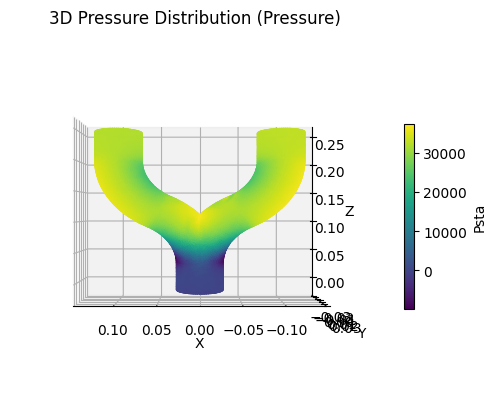

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 6]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Psta')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)

plt.show()


In [9]:
u_ave = data[:, 3].mean()
v_ave = data[:, 4].mean()
w_ave = data[:, 5].mean()
p_ave = data[:, 6].mean()
print(u_ave, v_ave, w_ave, p_ave)

-0.11899725 0.018432401 -99.79088 26749.492


# k3d Visualization

In [10]:
!pip install k3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00


In [11]:
import k3d
import numpy as np
from k3d.colormaps import matplotlib_color_maps
import os

# === データ準備 ===
x, y, z = data[:, 0], data[:, 1], data[:, 2]
pressure = data[:, 6]
positions = np.vstack([x, y, z]).T.astype(np.float32)
pressure_flat = pressure.flatten().astype(np.float32)

# === K3Dプロット作成 ===
plot = k3d.plot()

plt_points = k3d.points(positions=positions,
                        point_size=0.01,            # 適宜調整
                        attribute=pressure_flat,    # カラーマップの対象
                        color_map=matplotlib_color_maps.Jet,
                        opacity=0.8,                # 半透明
                        shader='3d')

plot += plt_points

# === 結果保存 ===
result_folder = './results'
os.makedirs(result_folder, exist_ok=True)

with open(result_folder + '/pressure_visualization.html', 'w') as fp:
    fp.write(plot.get_snapshot())

print('✅ 可視化HTMLを保存しました: ', result_folder + '/pressure_visualization.html')


✅ 可視化HTMLを保存しました:  ./results/pressure_visualization.html


# DeepXDE Install

In [8]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00


In [12]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# ココ重要データの定義
'''
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
print("ob_y.shape", ob_y.shape)
print("ob_t.shape", ob_t.shape)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
print("ob_xyt.shape", ob_xyt.shape)
'''

In [14]:
# PDEロス用の定義
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    w = y[:, 2:3]
    p = y[:, 3:4]

    # 一階微分
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    du_dz = dde.grad.jacobian(y, x, i=0, j=2)

    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    dv_dz = dde.grad.jacobian(y, x, i=1, j=2)

    dw_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dw_dy = dde.grad.jacobian(y, x, i=2, j=1)
    dw_dz = dde.grad.jacobian(y, x, i=2, j=2)

    dp_dx = dde.grad.jacobian(y, x, i=3, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=3, j=1)
    dp_dz = dde.grad.jacobian(y, x, i=3, j=2)

    # 二階微分（ラプラシアン項）
    d2u_dx2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2u_dz2 = dde.grad.hessian(y, x, component=0, i=2, j=2)

    d2v_dx2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2v_dy2 = dde.grad.hessian(y, x, component=1, i=1, j=1)
    d2v_dz2 = dde.grad.hessian(y, x, component=1, i=2, j=2)

    d2w_dx2 = dde.grad.hessian(y, x, component=2, i=0, j=0)
    d2w_dy2 = dde.grad.hessian(y, x, component=2, i=1, j=1)
    d2w_dz2 = dde.grad.hessian(y, x, component=2, i=2, j=2)

    # 連続の式
    continuity = du_dx + dv_dy + dw_dz

    # 運動量保存式（定常） C1 = rho, C2 = mu
    x_momentum = C1 * (u * du_dx + v * du_dy + w * du_dz) + dp_dx - C2 * (d2u_dx2 + d2u_dy2 + d2u_dz2)
    y_momentum = C1 * (u * dv_dx + v * dv_dy + w * dv_dz) + dp_dy - C2 * (d2v_dx2 + d2v_dy2 + d2v_dz2)
    z_momentum = C1 * (u * dw_dx + v * dw_dy + w * dw_dz) + dp_dz - C2 * (d2w_dx2 + d2w_dy2 + d2w_dz2)

    return [continuity, x_momentum, y_momentum, z_momentum]


In [13]:
# definet the DNN
layer_size = [3] + [50] * 10 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [15]:
# BCを定義　たとえば入り口の圧力をMaxで設定するなど

In [ ]:
# MSEを取るCAEデータとの模倣学習
'''
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)
observe_w = dde.icbc.PointSetBC(ob_xyt, ob_v, component=2)
observe_p = dde.icbc.PointSetBC(ob_xyt, ob_p, component=3)
'''

# U-Net define

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mish(x):
    return x * torch.tanh(F.softplus(x))

def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')  # Mish用のHeもrelu指定で問題なし
        if module.bias is not None:
            nn.init.zeros_(module.bias)

def init_weights_xavier(module):
    if isinstance(module, nn.Conv1d):
        gain = nn.init.calculate_gain('tanh')  # tanh に最適な gain を計算
        nn.init.xavier_normal_(module.weight, gain=gain)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


class PointNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.apply(init_weights_xavier)

    def forward(self, x):
        x = x.transpose(1, 2)        # [B, 3, N]
        x1 = F.tanh(self.conv1(x))     # [B, 64, N]
        x2 = F.tanh(self.conv2(x1))    # [B, 128, N]
        x3 = F.tanh(self.conv3(x2))    # [B, 256, N]
        return x1, x2, x3

class PointNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv1 = nn.Conv1d(256 + 128, 128, 1)
        self.upconv2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 4, 1)
        self.apply(init_weights_xavier)

    def forward(self, x1, x2, x3):
        up1 = F.tanh(self.upconv1(torch.cat([x3, x2], dim=1)))  # [B, 128, N]
        up2 = F.tanh(self.upconv2(torch.cat([up1, x1], dim=1))) # [B, 64, N]
        out = self.out(up2)                                   # [B, 4, N]
        return out.transpose(1, 2)                            # [B, N, 4]

class PointUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):  # x: [B, N, 3]
        x1, x2, x3 = self.encoder(x)
        out = self.decoder(x1, x2, x3)
        return out  # [B, N, 4]


# dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CFDDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        data = np.load(data_path)  # shape: (N, 7)
        self.inputs = data[:, 0:3].astype(np.float32)  # x, y, z
        self.targets = data[:, 3:7].astype(np.float32)  # u, v, w, p
        #self.targets = data[:, 6].astype(np.float32)  # p

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [ ]:
'''
class CFDPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, n_points=1024):
        data = np.load(data_path).astype(np.float32)  # shape: [N_total, 7]
        self.n_points = n_points
        self.inputs = data[:, 0:3]
        self.raw_targets = data[:, 3:7]
        #self.raw_targets = data[:, 6]

        self.p_min = self.raw_targets.min()
        self.p_max = self.raw_targets.max()
        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)

        total_points = len(self.inputs)
        total_groups = total_points // n_points
        self.inputs = self.inputs[:total_groups * n_points].reshape(total_groups, n_points, 3)
        self.targets = self.targets[:total_groups * n_points].reshape(total_groups, n_points, 4)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_p):
        return norm_p * (self.p_max - self.p_min) + self.p_min
'''

'\nclass CFDPointCloudDataset(torch.utils.data.Dataset):\n    def __init__(self, data_path, n_points=1024):\n        data = np.load(data_path).astype(np.float32)  # shape: [N_total, 7]\n        self.n_points = n_points\n        self.inputs = data[:, 0:3]\n        self.raw_targets = data[:, 3:7]\n        #self.raw_targets = data[:, 6]\n\n        self.p_min = self.raw_targets.min()\n        self.p_max = self.raw_targets.max()\n        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)\n\n        total_points = len(self.inputs)\n        total_groups = total_points // n_points\n        self.inputs = self.inputs[:total_groups * n_points].reshape(total_groups, n_points, 3)\n        self.targets = self.targets[:total_groups * n_points].reshape(total_groups, n_points, 4)\n\n    def __len__(self):\n        return len(self.inputs)\n\n    def __getitem__(self, idx):\n        return self.inputs[idx], self.targets[idx]\n\n    def inverse_transform(self, norm_p):\n        ret

In [ ]:
class CFDPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, n_points=1024):
        data = np.load(data_path).astype(np.float32)  # shape: [N_total, 7]
        self.n_points = n_points

        self.inputs = data[:, 0:3]
        self.raw_targets = data[:, 3:7]  # [u, v, w, p]

        # --- スケーリング ---
        u, v, w, p = self.raw_targets[:, 0], self.raw_targets[:, 1], self.raw_targets[:, 2], self.raw_targets[:, 3]

        # 標準化: u, v, w
        self.u_mean, self.u_std = u.mean(), u.std()
        self.v_mean, self.v_std = v.mean(), v.std()
        self.w_mean, self.w_std = w.mean(), w.std()

        u_scaled = (u - self.u_mean) / self.u_std
        v_scaled = (v - self.v_mean) / self.v_std
        w_scaled = (w - self.w_mean) / self.w_std

        # Min-Max: p
        self.p_min, self.p_max = p.min(), p.max()
        p_scaled = (p - self.p_min) / (self.p_max - self.p_min)

        self.targets = np.stack([u_scaled, v_scaled, w_scaled, p_scaled], axis=1)

        total_points = len(self.inputs)
        total_groups = total_points // n_points
        self.inputs = self.inputs[:total_groups * n_points].reshape(total_groups, n_points, 3)
        self.targets = self.targets[:total_groups * n_points].reshape(total_groups, n_points, 4)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_targets):
        u = norm_targets[..., 0] * self.u_std + self.u_mean
        v = norm_targets[..., 1] * self.v_std + self.v_mean
        w = norm_targets[..., 2] * self.w_std + self.w_mean
        p = norm_targets[..., 3] * (self.p_max - self.p_min) + self.p_min
        return np.stack([u, v, w, p], axis=-1)


In [ ]:
# データ読み込み
train_dataset = CFDPointCloudDataset('cfd_data.npy')
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, drop_last=False)

# note
独立点群のため、今後はk-meansなどで近距離点群を集めてバッチ化して学習できるようにすること

# Trainer

In [7]:
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training Loop (with loss tracking)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10000
loss_history = [] # リストを初期化してlossを保存


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_u_loss = 0.0
    epoch_v_loss = 0.0
    epoch_w_loss = 0.0
    epoch_p_loss = 0.0

    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 4]
        outputs = model(batch_inputs)             # [B, N, 4]

        optimizer.zero_grad()

        u_loss = criterion(outputs[:, :, 0], batch_targets[:, :, 0])
        v_loss = criterion(outputs[:, :, 1], batch_targets[:, :, 1])
        w_loss = criterion(outputs[:, :, 2], batch_targets[:, :, 2])
        p_loss = criterion(outputs[:, :, 3], batch_targets[:, :, 3])


        p_weight = 1  # または 3e-5
        loss = u_loss + v_loss + w_loss + p_weight * p_loss
        #loss = u_loss + v_loss + w_loss + p_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_u_loss += u_loss.item()
        epoch_v_loss += v_loss.item()
        epoch_w_loss += w_loss.item()
        epoch_p_loss += p_loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_u_loss = epoch_u_loss / len(train_loader)
    avg_v_loss = epoch_v_loss / len(train_loader)
    avg_w_loss = epoch_w_loss / len(train_loader)
    avg_p_loss = epoch_p_loss / len(train_loader)

    loss_history.append(avg_epoch_loss)

    if (epoch + 1) % 500 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>4} - Total Loss: {avg_epoch_loss:.6f} | u: {avg_u_loss:.6f}, v: {avg_v_loss:.6f}, w: {avg_w_loss:.6f}, p: {avg_p_loss:.6f}")


NameError: name 'torch' is not defined

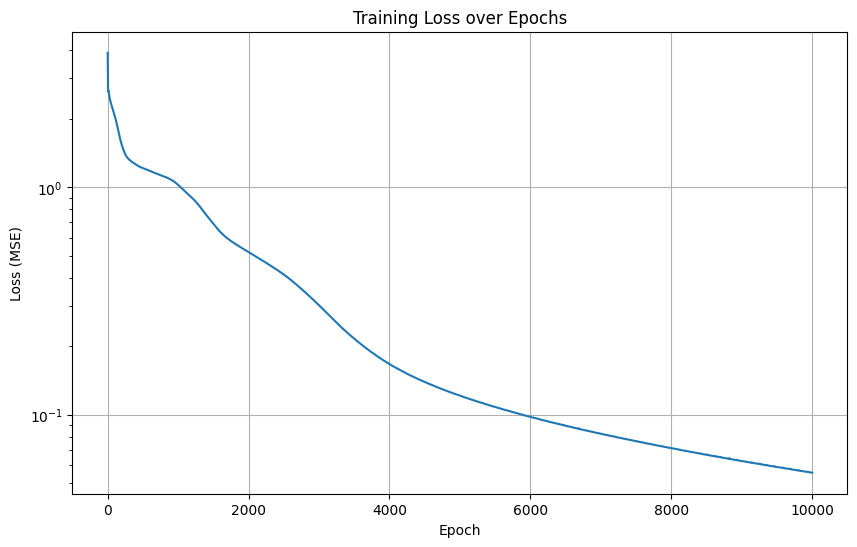

In [ ]:
# prompt: plt.yをlogにして

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.yscale('log')  # ここでy軸を対数スケールに設定
plt.grid(True)
plt.show()


# Evaluation

Predicting: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]



R² Score (u velocity): 0.9944


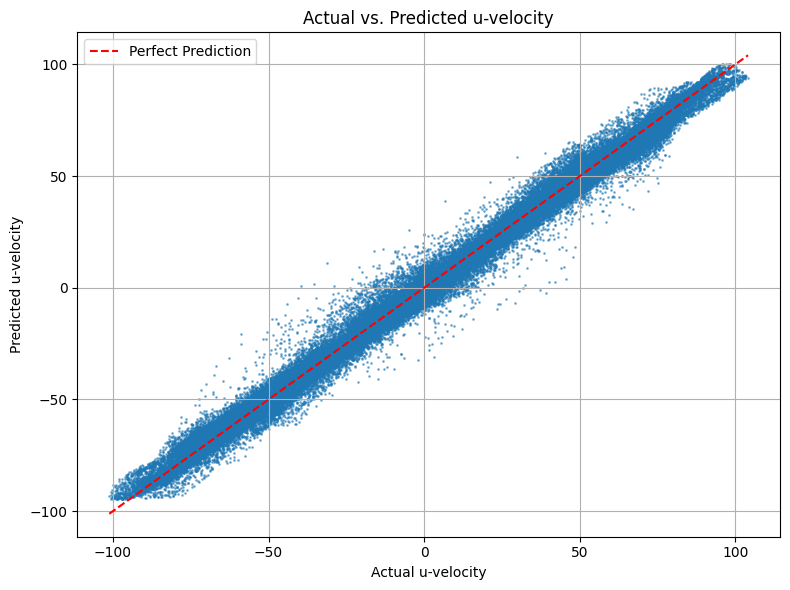

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 4]

        outputs = model(batch_inputs)             # [B, N, 4]
        u_pred = outputs[:, :, 0].cpu().numpy()   # ← u = index 0
        u_true = batch_targets[:, :, 0].cpu().numpy()

        all_predictions.append(u_pred)
        all_targets.append(u_true)

# 結合して [N_all] に
predicted_u_normalized = np.concatenate(all_predictions, axis=0).flatten()
target_u_normalized = np.concatenate(all_targets, axis=0).flatten()

# 💡 uのみを元スケールに戻す（mean, stdを使って手動で復元）
u_mean = train_dataset.u_mean
u_std = train_dataset.u_std

predicted_u_original = predicted_u_normalized * u_std + u_mean
target_u_original = target_u_normalized * u_std + u_mean

# R²スコア
r2 = r2_score(target_u_original, predicted_u_original)
print(f"\nR² Score (u velocity): {r2:.4f}")

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(target_u_original, predicted_u_original, alpha=0.5, s=1)
plt.xlabel("Actual u-velocity")
plt.ylabel("Predicted u-velocity")
plt.title("Actual vs. Predicted u-velocity")
plt.grid(True)

# 完全一致線
min_val = min(target_u_original.min(), predicted_u_original.min())
max_val = max(target_u_original.max(), predicted_u_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Predicting v: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s]



R² Score (v velocity): 0.9638


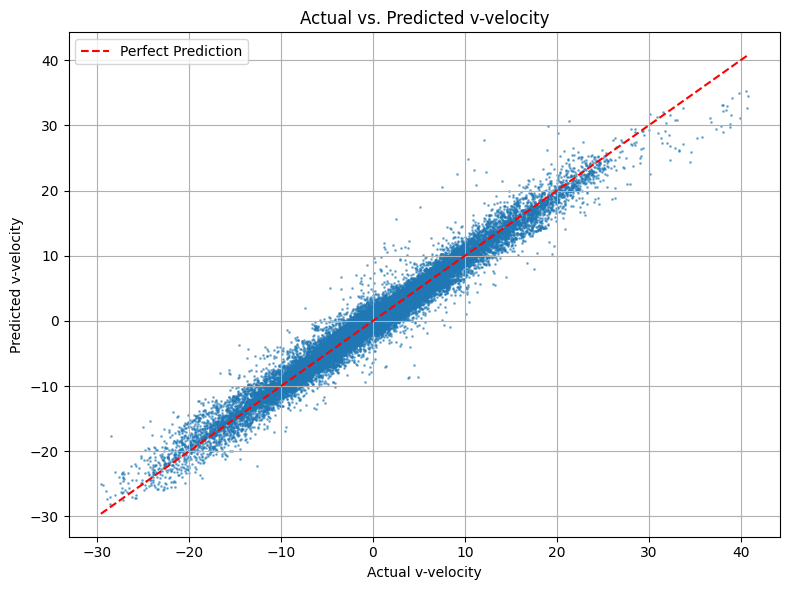

In [ ]:
# -------- v の評価 --------
all_v_predictions = []
all_v_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting v"):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        outputs = model(batch_inputs)

        v_pred = outputs[:, :, 1].cpu().numpy()  # v = index 1
        v_true = batch_targets[:, :, 1].cpu().numpy()

        all_v_predictions.append(v_pred)
        all_v_targets.append(v_true)

# フラット化
predicted_v_normalized = np.concatenate(all_v_predictions, axis=0).flatten()
target_v_normalized = np.concatenate(all_v_targets, axis=0).flatten()

# 元スケールに復元
v_mean = train_dataset.v_mean
v_std = train_dataset.v_std

predicted_v_original = predicted_v_normalized * v_std + v_mean
target_v_original = target_v_normalized * v_std + v_mean

# R² スコア
r2_v = r2_score(target_v_original, predicted_v_original)
print(f"\nR² Score (v velocity): {r2_v:.4f}")

# 散布図プロット
plt.figure(figsize=(8, 6))
plt.scatter(target_v_original, predicted_v_original, alpha=0.5, s=1)
plt.xlabel("Actual v-velocity")
plt.ylabel("Predicted v-velocity")
plt.title("Actual vs. Predicted v-velocity")
plt.grid(True)

# 完全一致線
min_val = min(target_v_original.min(), predicted_v_original.min())
max_val = max(target_v_original.max(), predicted_v_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Predicting w: 100%|██████████| 1/1 [00:00<00:00, 31.63it/s]



R² Score (w velocity): 0.9866


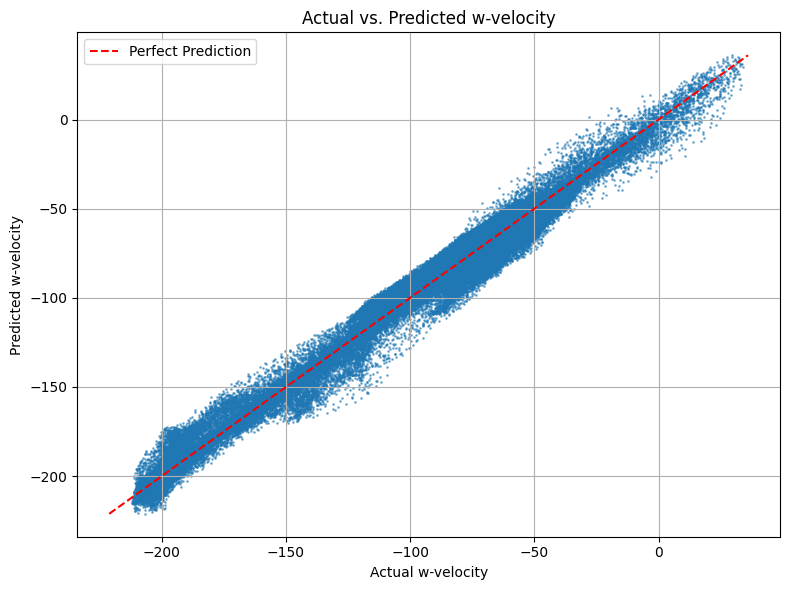

In [ ]:
# -------- w の評価 --------
all_w_predictions = []
all_w_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting w"):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        outputs = model(batch_inputs)

        w_pred = outputs[:, :, 2].cpu().numpy()  # w = index 2
        w_true = batch_targets[:, :, 2].cpu().numpy()

        all_w_predictions.append(w_pred)
        all_w_targets.append(w_true)

# フラット化
predicted_w_normalized = np.concatenate(all_w_predictions, axis=0).flatten()
target_w_normalized = np.concatenate(all_w_targets, axis=0).flatten()

# 元スケールに復元
w_mean = train_dataset.w_mean
w_std = train_dataset.w_std

predicted_w_original = predicted_w_normalized * w_std + w_mean
target_w_original = target_w_normalized * w_std + w_mean

# R² スコア
r2_w = r2_score(target_w_original, predicted_w_original)
print(f"\nR² Score (w velocity): {r2_w:.4f}")

# 散布図プロット
plt.figure(figsize=(8, 6))
plt.scatter(target_w_original, predicted_w_original, alpha=0.5, s=1)
plt.xlabel("Actual w-velocity")
plt.ylabel("Predicted w-velocity")
plt.title("Actual vs. Predicted w-velocity")
plt.grid(True)

# 完全一致線
min_val = min(target_w_original.min(), predicted_w_original.min())
max_val = max(target_w_original.max(), predicted_w_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Predicting p: 100%|██████████| 1/1 [00:00<00:00, 32.58it/s]



R² Score (pressure): 0.9909


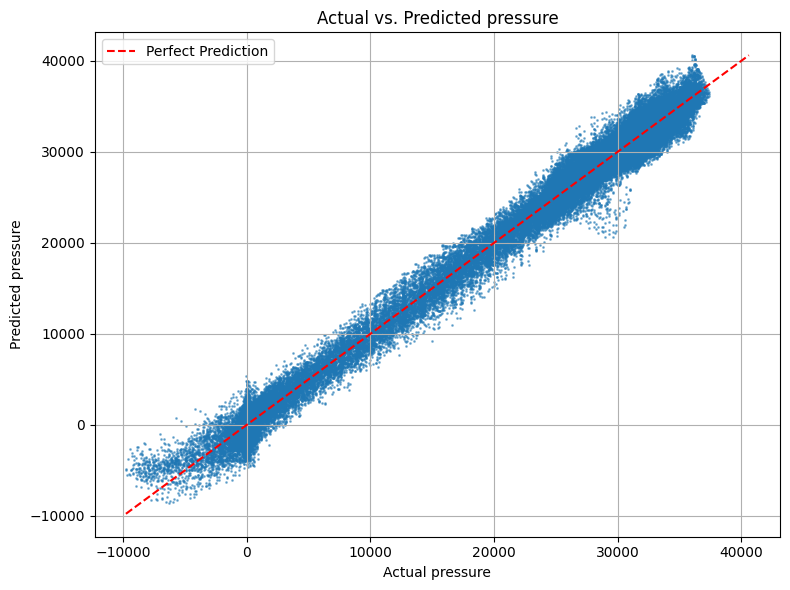

In [ ]:
# -------- p の評価 --------
all_p_predictions = []
all_p_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting p"):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        outputs = model(batch_inputs)

        p_pred = outputs[:, :, 3].cpu().numpy()  # p = index 3
        p_true = batch_targets[:, :, 3].cpu().numpy()

        all_p_predictions.append(p_pred)
        all_p_targets.append(p_true)

# フラット化
predicted_p_normalized = np.concatenate(all_p_predictions, axis=0).flatten()
target_p_normalized = np.concatenate(all_p_targets, axis=0).flatten()

# 元スケールに復元（min-max scaling）
p_min = train_dataset.p_min
p_max = train_dataset.p_max

predicted_p_original = predicted_p_normalized * (p_max - p_min) + p_min
target_p_original = target_p_normalized * (p_max - p_min) + p_min

# R² スコア
r2_p = r2_score(target_p_original, predicted_p_original)
print(f"\nR² Score (pressure): {r2_p:.4f}")

# 散布図プロット
plt.figure(figsize=(8, 6))
plt.scatter(target_p_original, predicted_p_original, alpha=0.5, s=1)
plt.xlabel("Actual pressure")
plt.ylabel("Predicted pressure")
plt.title("Actual vs. Predicted pressure")
plt.grid(True)

# 完全一致線
min_val = min(target_p_original.min(), predicted_p_original.min())
max_val = max(target_p_original.max(), predicted_p_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


# Counter

Predicting p: 100%|██████████| 1/1 [00:00<00:00, 33.09it/s]


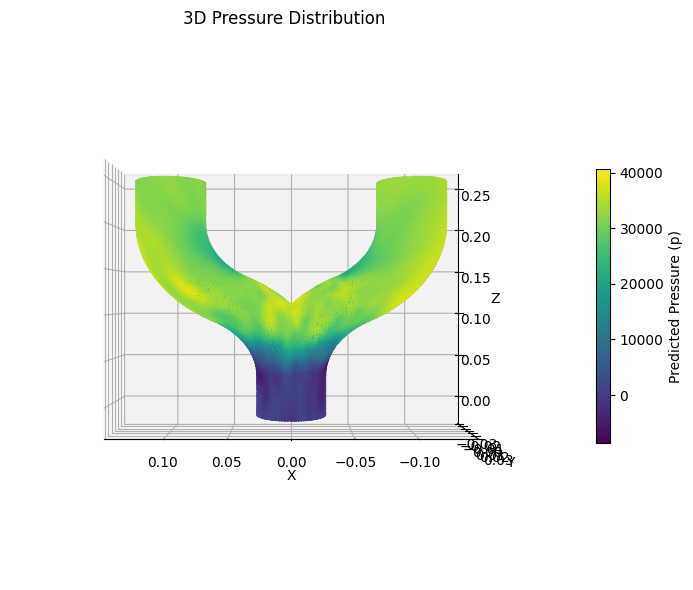

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
all_pred_p = []  # 推論p [B, N]
all_xyz = []     # 座標 [B, N, 3]

with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting p"):
        batch_inputs = batch_inputs.to(device)         # [B, N, 3]
        outputs = model(batch_inputs)                  # [B, N, 4]
        p_pred = outputs[:, :, 3].cpu().numpy()        # [B, N]
        xyz = batch_inputs.cpu().numpy()               # [B, N, 3]

        all_pred_p.append(p_pred.reshape(-1))          # [B*N]
        all_xyz.append(xyz.reshape(-1, 3))             # [B*N, 3]

# 結合
p_pred_flat = np.concatenate(all_pred_p, axis=0)       # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)              # [total_points, 3]

# 正規化解除
p_min = train_dataset.p_min
p_max = train_dataset.p_max
p_original = p_pred_flat * (p_max - p_min) + p_min     # 元スケールに復元

# 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(p_original) == len(x), "Length mismatch in visualization!"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=p_original, cmap='viridis', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted Pressure (p)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution')
ax.view_init(elev=0, azim=90)  # 真上から俯瞰
plt.tight_layout()
plt.show()


Predicting w: 100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


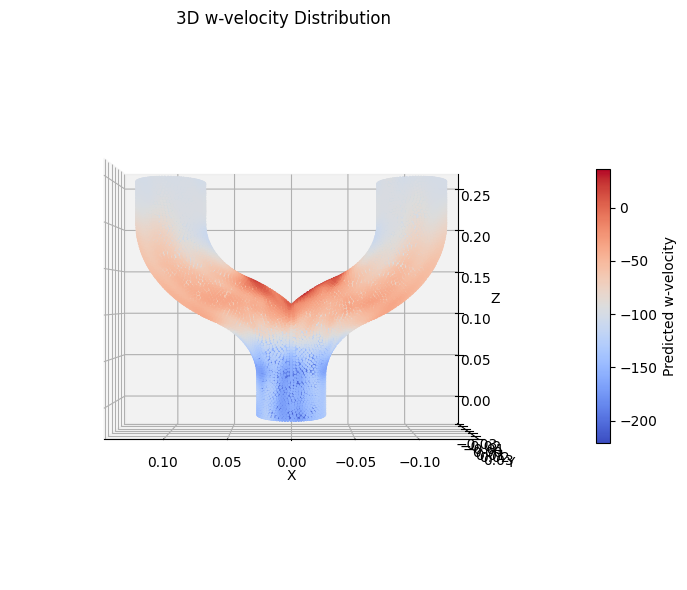

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
all_pred_w = []  # 推論w [B, N]
all_xyz = []     # 座標 [B, N, 3]

with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting w"):
        batch_inputs = batch_inputs.to(device)         # [B, N, 3]
        outputs = model(batch_inputs)                  # [B, N, 4]
        w_pred = outputs[:, :, 2].cpu().numpy()        # w = index 2
        xyz = batch_inputs.cpu().numpy()               # [B, N, 3]

        all_pred_w.append(w_pred.reshape(-1))          # [B*N]
        all_xyz.append(xyz.reshape(-1, 3))             # [B*N, 3]

# 結合
w_pred_flat = np.concatenate(all_pred_w, axis=0)       # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)              # [total_points, 3]

# 正規化解除（Zスコア → 実値）
w_mean = train_dataset.w_mean
w_std = train_dataset.w_std
w_original = w_pred_flat * w_std + w_mean              # 元スケールに復元

# 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(w_original) == len(x), "Length mismatch in visualization!"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=w_original, cmap='coolwarm', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted w-velocity')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D w-velocity Distribution')
ax.view_init(elev=0, azim=90)
plt.tight_layout()
plt.show()


Predicting u: 100%|██████████| 1/1 [00:00<00:00, 33.06it/s]


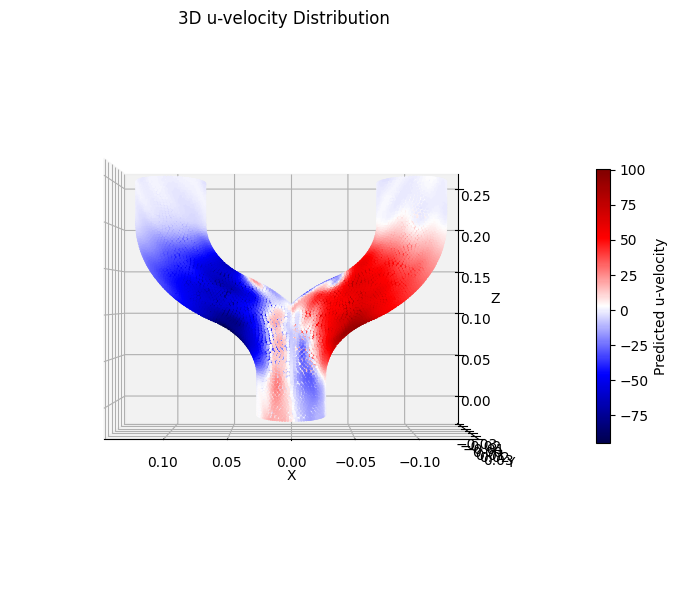

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
all_pred_u = []  # 推論u [B, N]
all_xyz = []     # 座標 [B, N, 3]

with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting u"):
        batch_inputs = batch_inputs.to(device)         # [B, N, 3]
        outputs = model(batch_inputs)                  # [B, N, 4]
        u_pred = outputs[:, :, 0].cpu().numpy()        # u = index 0
        xyz = batch_inputs.cpu().numpy()               # [B, N, 3]

        all_pred_u.append(u_pred.reshape(-1))          # [B*N]
        all_xyz.append(xyz.reshape(-1, 3))             # [B*N, 3]

# 結合
u_pred_flat = np.concatenate(all_pred_u, axis=0)       # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)              # [total_points, 3]

# 正規化解除（Zスコア → 実スケール）
u_mean = train_dataset.u_mean
u_std = train_dataset.u_std
u_original = u_pred_flat * u_std + u_mean              # 元スケールに復元

# 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(u_original) == len(x), "Length mismatch in visualization!"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=u_original, cmap='seismic', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted u-velocity')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D u-velocity Distribution')
ax.view_init(elev=0, azim=90)
plt.tight_layout()
plt.show()


Predicting v: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


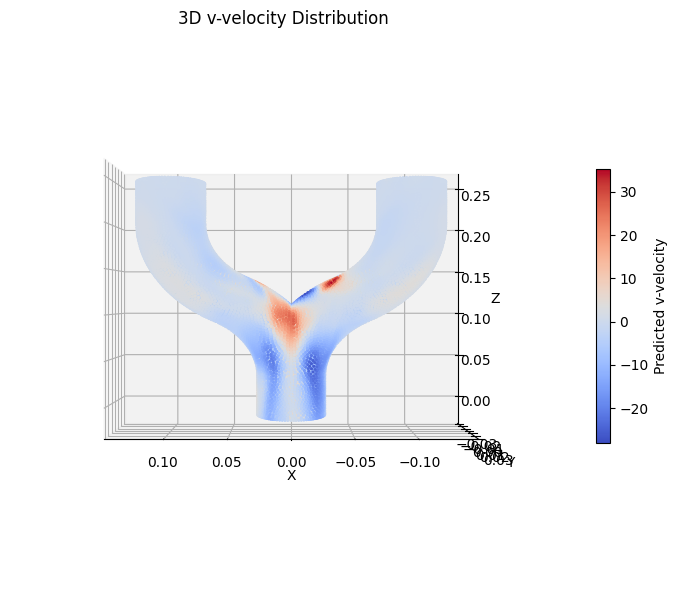

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
all_pred_v = []  # 推論v [B, N]
all_xyz = []     # 座標 [B, N, 3]

with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting v"):
        batch_inputs = batch_inputs.to(device)         # [B, N, 3]
        outputs = model(batch_inputs)                  # [B, N, 4]
        v_pred = outputs[:, :, 1].cpu().numpy()        # v = index 1
        xyz = batch_inputs.cpu().numpy()               # [B, N, 3]

        all_pred_v.append(v_pred.reshape(-1))          # [B*N]
        all_xyz.append(xyz.reshape(-1, 3))             # [B*N, 3]

# 結合
v_pred_flat = np.concatenate(all_pred_v, axis=0)       # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)              # [total_points, 3]

# 正規化解除（Zスコア → 実スケール）
v_mean = train_dataset.v_mean
v_std = train_dataset.v_std
v_original = v_pred_flat * v_std + v_mean              # 元スケールに復元

# 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(v_original) == len(x), "Length mismatch in visualization!"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=v_original, cmap='coolwarm', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted v-velocity')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D v-velocity Distribution')
ax.view_init(elev=0, azim=90)
plt.tight_layout()
plt.show()


# Individual scalre Training using U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

# --------------------------------------------
# Mish Activation
# --------------------------------------------
def mish(x):
    return x * torch.tanh(F.softplus(x))

# --------------------------------------------
# Kaiming Initialization
# --------------------------------------------
def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# --------------------------------------------
# Simple PointNet-like U-Net Block for Scalar Output
# --------------------------------------------
class ScalarUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)

        self.up1 = nn.Conv1d(256 + 128, 128, 1)
        self.up2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 1, 1)

        self.apply(init_weights_xavier)

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, 3, N]
        x1 = mish(self.conv1(x))
        x2 = mish(self.conv2(x1))
        x3 = mish(self.conv3(x2))

        up1 = mish(self.up1(torch.cat([x3, x2], dim=1)))
        up2 = mish(self.up2(torch.cat([up1, x1], dim=1)))
        out = self.out(up2)  # [B, 1, N]
        return out.transpose(1, 2)  # [B, N, 1]

# --------------------------------------------
# Combined Model with 4 U-Nets and Physics Loss
# --------------------------------------------
class PhysicsInformedCFDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_u = ScalarUNet()
        self.net_v = ScalarUNet()
        self.net_w = ScalarUNet()
        self.net_p = ScalarUNet()

    def forward(self, coords):
        # coords: [B, N, 3] with requires_grad=True
        u = self.net_u(coords)  # [B, N, 1]
        v = self.net_v(coords)
        w = self.net_w(coords)
        p = self.net_p(coords)
        return u, v, w, p

    def pde_loss(self, coords, u, v, w, p, rho=1.0, mu=1e-3):
        grads_u = grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # [B, N, 3]
        grads_v = grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        grads_w = grad(w, coords, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        grads_p = grad(p, coords, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        du_dx = grads_u[:, :, 0]
        dv_dy = grads_v[:, :, 1]
        dw_dz = grads_w[:, :, 2]
        continuity = du_dx + dv_dy + dw_dz  # [B, N]
        loss_cont = torch.mean(continuity ** 2)

        # ラプラシアン項
        def laplacian(f, coords):
            grad_f = grad(f, coords, grad_outputs=torch.ones_like(f), create_graph=True)[0]
            lap = 0
            for i in range(3):
                grad2 = grad(grad_f[:, :, i], coords, grad_outputs=torch.ones_like(grad_f[:, :, i]), create_graph=True)[0][:, :, i]
                lap += grad2
            return lap

        # x方向のNS項（例）
        inertia_u = u * grads_u[:, :, 0] + v * grads_u[:, :, 1] + w * grads_u[:, :, 2]  # advective term
        dp_dx = grads_p[:, :, 0]
        lap_u = laplacian(u, coords)
        ns_res_x = rho * inertia_u + dp_dx - mu * lap_u
        loss_ns_x = torch.mean(ns_res_x ** 2)

        # y方向
        inertia_v = u * grads_v[:, :, 0] + v * grads_v[:, :, 1] + w * grads_v[:, :, 2]
        dp_dy = grads_p[:, :, 1]
        lap_v = laplacian(v, coords)
        ns_res_y = rho * inertia_v + dp_dy - mu * lap_v
        loss_ns_y = torch.mean(ns_res_y ** 2)

        # z方向
        inertia_w = u * grads_w[:, :, 0] + v * grads_w[:, :, 1] + w * grads_w[:, :, 2]
        dp_dz = grads_p[:, :, 2]
        lap_w = laplacian(w, coords)
        ns_res_z = rho * inertia_w + dp_dz - mu * lap_w
        loss_ns_z = torch.mean(ns_res_z ** 2)

        loss_ns = loss_ns_x + loss_ns_y + loss_ns_z
        return loss_cont, loss_ns
